In [40]:
# imports
import cv2
import numpy as np
from scipy.spatial.distance import pdist, squareform
import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from ultralytics import YOLO
from IPython.display import display, clear_output
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import dill
import ipywidgets as widgets
%matplotlib notebook

### Run Calibration Sequence

In [24]:
video_dir = 'Strike zone overlay\please_work\Calibration_videos'

# Get a list of all files in the directory
files = os.listdir(video_dir)
print(len(files))
# Filter out non-video files (optional)
video_files = [f for f in files if f.endswith(('.mp4', '.avi', '.MOV', '.mkv'))]

# Loop through each video file
for video_file in video_files:
    # Construct the full video file path
    video_path = os.path.join(video_dir, video_file)
    
    # Capture the video
    cap = cv2.VideoCapture(video_path)

    # Read the first frame
    ret, frame = cap.read()

    # Check if frame is read correctly
    if ret:
        # Construct the output image file path
        output_image_path = os.path.join(video_dir, f"{os.path.splitext(video_file)[0]}_first_frame.jpg")
        
        # Save the frame as an image
        cv2.imwrite(output_image_path, frame)
    else:
        print(f"Could not read the first frame of {video_file}")

    # Release the video capture object
    cap.release()

print("First frames extracted and saved successfully.")









38
First frames extracted and saved successfully.


In [25]:
# Defining the dimensions of checkerboard
CHECKERBOARD = (6,9)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
# Creating vector to store vectors of 3D points for each checkerboard image
objpoints = []
# Creating vector to store vectors of 2D points for each checkerboard image
imgpoints = [] 
 

# defining world points
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2) #length of square in meters
prev_img_shape = None
 

# Extracting path of individual image stored in a given directory
images = glob.glob('Strike zone overlay/please_work/Calibration_videos/*.JPG')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    # If desired number of corners are found in the image then ret = true
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
     
    """
    If desired number of corner are detected,
    we refine the pixel coordinates and display 
    them on the images of checker board
    """
    if ret == True:
        objpoints.append(objp)
        # refining pixel coordinates for given 2d points.
        corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
         
        imgpoints.append(corners2)
 
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
     
#     cv2.imshow('img',img)
#     cv2.waitKey(1)
#     cv2.destroyAllWindows()

# cv2.destroyAllWindows()
# cv2.waitKey(1)
 
h,w = img.shape[:2]
 
"""
Performing camera calibration by 
passing the value of known 3D points (objpoints)
and corresponding pixel coordinates of the 
detected corners (imgpoints)
"""
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
 
print("Camera matrix : \n")
print(mtx)
print("dist : \n")
print(dist)
print("rvecs : \n")
print(rvecs)
print("tvecs : \n")
print(tvecs)

print(f"fx: {mtx[0][0]}, fy: {mtx[1][1]}")
print(f"cx: {mtx[0][2]}, cy: {mtx[1][2]}")

fx = mtx[0][0]
fy = mtx[1][1]
cx = mtx[0][2]
cy = mtx[1][2]

Camera matrix : 

[[       1683           0      948.77]
 [          0      1682.5       536.7]
 [          0           0           1]]
dist : 

[[    0.22893    -0.97047   0.0017989  0.00029127      0.7911]]
rvecs : 

(array([[    0.63076],
       [   -0.50146],
       [     -1.552]]), array([[    0.42207],
       [    0.28731],
       [     -1.523]]), array([[    0.29532],
       [   -0.75873],
       [    -1.6769]]), array([[    0.71305],
       [  -0.038688],
       [    -1.2707]]), array([[    0.28739],
       [    0.41125],
       [      -1.89]]), array([[    0.16704],
       [   -0.61094],
       [    -1.6107]]), array([[    0.77946],
       [    0.13259],
       [    -1.3241]]), array([[    0.40671],
       [     0.5265],
       [    -1.6953]]), array([[   -0.28227],
       [   -0.43158],
       [    -1.5496]]), array([[      0.663],
       [    0.48857],
       [    -1.4868]]), array([[    0.77573],
       [     -0.603],
       [    -1.5025]]), array([[  -0.085845],
       [  

### Functions for identifying and ordering plate corners

In [26]:
print(ret)

0.29678881149018566


In [27]:
# Load the model
model = YOLO('bestwpingpong.pt')

In [28]:
def convert_to_real_world_coordinates(x, y, d_pix, fx, fy, cx, cy, true_diameter):
    # Calculate real-world coordinates
    Z = (fx * true_diameter) / d_pix
    X = ((x - cx) * Z) / fx
    Y = ((y - cy) * Z) / fy

    return X, Y, Z

def meters_to_inches(meters):
    return meters * 39.3701  

def process_image(image_path):
    # Load the image with OpenCV
    current_frame = cv2.imread(image_path)
    
    # Ensure the image was loaded
    if current_frame is None:
        print(f"Failed to load image {image_path}")
        return
    
    # Predict using the model for baseball class (class_id 32)
    results = model.predict(current_frame,classes = [80])
   
    # points list to return
    points = []

    # Iterate through the results
    for result in results:
        boxes = result.boxes

        if boxes.conf.size(0) > 0:
            # There are detections
            for i in range(boxes.xyxy.size(0)): # For each detection
                # Extract bounding box coordinates
                x1, y1, x2, y2 = map(int, boxes.xyxy[i].tolist())
                
                # Calculate the diameter of the baseball (approximation)
                d_pix = ((x2 - x1) + (y2 - y1)) / 2
                
                # if (d_pix < 40):
                #     continue  # TODO: REMOVE LATER (filter out objects too small to be the balls)

                # Draw rectangle around the baseball
                cv2.rectangle(current_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                print(f"num detections: {len(boxes)}, x1: {x1} y1: {y1} x2: {x2} y2: {y2}")

                
                print(f"Diameter of baseball in pixels: {d_pix}")
    
                # get midpoint of the ball in the image (pixels)
                y = y1 + (y2 - y1) / 2
                x = x1 + (x2 - x1) / 2
                print(f"{x} {y}")
                print(x)
                # calculate real-world depth
                X, Y, Z = convert_to_real_world_coordinates(x, y, d_pix, fx, fy, cx, cy, 0.04)
                points.append((meters_to_inches(X), meters_to_inches(Y), meters_to_inches(Z)))

                print(f"Real-world coordinates. X:{X} Y:{Y} Z:{Z}")
                # cv2.putText(current_frame, f"Real world coordinates:", (x1, y1-500), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
                cv2.putText(current_frame, f"Point: {len(points) - 1}", (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
                # cv2.putText(current_frame, f"X:{X}", (x1, y1-300), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
                # cv2.putText(current_frame, f"Y:{Y}", (x1, y1-200), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
                # cv2.putText(current_frame, f"Z:{Z}", (x1, y1-100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
                # cv2.circle(current_frame, (int(x),int(y)), radius=5, color=(0, 0, 255), thickness=-1)
                    
    # Display the modified frame with bounding boxes
    cv2.imshow("Detected Baseball", current_frame)
    cv2.waitKey(0)  # Wait for a key press to close
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    cv2.imwrite('detected_balls.jpg',current_frame)
    return points

def compute_mse_for_point(point_index, distance_matrix, expected_distances):
    # check for only 5 points
    if len(distance_matrix) != 5:
        raise ValueError("Distance matrix must have 5 points corresponding to the corners of the home plate.")

    actual_distances = np.sort(np.delete(distance_matrix[point_index], point_index))
    # print(actual_distances)

    mse = np.mean((actual_distances - expected_distances) ** 2)
    return mse


# Home Plate Configuration:
#           3           2
#           _____________
#           |           | 
#    (left) |           | (right)
#           |           |
#           4           1
#            \         /
#             \       /
#              \     /
#               \   /
#                \ /
#                 0 (Front of the plate)
def determine_plate_corners(points, distance_matrix, front_tip_index):
    # check for only 5 points
    if len(distance_matrix) != 5:
        raise ValueError("Distance matrix must have 5 points corresponding to the corners of the home plate.")

    num_points = len(points)
    # Exclude front tip from possible back corners
    other_indices = [i for i in range(num_points) if i != front_tip_index]
    print(other_indices)

    # Calculate distances from front tip to other points
    distances_from_front = distance_matrix[front_tip_index, other_indices]
    print(distances_from_front)

    # Identify back corners as the two farthest points from the front tip
    back_corners_indices = np.argsort(-distances_from_front)[:2]  # Get indices of two largest distances
    back_corners = [other_indices[i] for i in back_corners_indices]

    # The remaining point is the side corners
    remaining_index = list(set(other_indices) - set(back_corners))

    # find the closest point
    if np.linalg.norm(points[remaining_index[0]]) < np.linalg.norm(points[remaining_index[1]]):
        closest_point_index = remaining_index[0]
        further_point_index = remaining_index[1]
    else:
        closest_point_index = remaining_index[1]
        further_point_index = remaining_index[0]
    print(closest_point_index)

    # find the closest side
    if (distance_matrix[closest_point_index, back_corners[0]] < distance_matrix[closest_point_index, back_corners[1]]):
        closest_side_back_point_index = back_corners[0]
        further_side_back_point_index = back_corners[1]
    else:
        closest_side_back_point_index = back_corners[1]
        further_side_back_point_index = back_corners[0]

    # determine handed-ness of the batter
    if points[closest_point_index][0] < points[further_point_index][0]:  # compare x values of the closest point and the further point, if the x value of the further point is greater, we are standing on the left side of the plate and the batter is right-handed
        print("Right-handed batter (batter is on the left side of plate)")
        return [front_tip_index, further_point_index, further_side_back_point_index, closest_side_back_point_index, closest_point_index]
    else:
        print("Left-handed batter (batter is on the right side of plate)")
        return [front_tip_index, closest_point_index, closest_side_back_point_index, further_side_back_point_index, further_point_index]

def order_homeplate_points(frame, points, pingpong_id=80):
    # for detection in detections:
    #     # calculate real-world depth
    #     X, Y, Z = convert_to_real_world_coordinates(detection.x, detection.y, detection.width, fx, fy, cx, cy, 0.04)
    #     X, Y, Z = meters_to_inches(X), meters_to_inches(Y), meters_to_inches(Z)
    #     points.append([X, Y, Z])
    #     print(f"Real-world coordinates. X:{X} Y:{Y} Z:{Z}")

    #     # display real-world coordinates
    #     cv2.putText(frame, f"Real world coordinates for point {len(points) - 1}", (int(detection.x), int(detection.y - 400)), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
    #     cv2.putText(frame, f"X:{X}", (int(detection.x), int(detection.y - 300)), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
    #     cv2.putText(frame, f"Y:{Y}", (int(detection.x), int(detection.y - 200)), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
    #     cv2.putText(frame, f"Z:{Z}", (int(detection.x), int(detection.y - 100)), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)

    # # Show image
    # print("here")
    # cv2.imshow('Image Frame', frame)
    # cv2.waitKey(0) # waits until a key is pressed
    # cv2.destroyAllWindows() # destroys the window showing image
    # cv2.waitKey(1)

    # Find which points correspond to which corner of home plate
    # 1. Find the front tip by computing MSE for each point as the front tip
    distance_matrix = squareform(pdist(points, 'euclidean'))
    print(distance_matrix)
    expected_distances = np.array([11.8, 11.8, 17, 17]) #convert from inches to meters
    mse_scores = []
    for i in range(len(points)):
        mse = compute_mse_for_point(i, distance_matrix, expected_distances)
        mse_scores.append(mse)
        print(f"MSE for point {i} as back tip: {mse}")

    # Determine which point has the lowest MSE
    front_tip_index = np.argmin(mse_scores)
    print(f"Point {front_tip_index} is likely the front tip of the home plate based on MSE.")

    # 2. Find the other 4 corners
    corners = determine_plate_corners(points, distance_matrix, front_tip_index)
    print("Identified corners:", corners)
    return corners,[points[corners[0]], points[corners[1]], points[corners[2]], points[corners[3]], points[corners[4]]]



# Test image from pitching video

In [29]:
cap = cv2.VideoCapture('Strike zone overlay/please_work/IMG_5296.MOV') #Read in pitch from folder
frame_list = []  #List where we will store each frame of the video
while(cap.isOpened()): 
      
# Capture frame-by-frame 
    ret, frame = cap.read() 
    if ret == True: 
    # Display the resulting frame 
#         cv2.imshow('Frame', frame) 
        frame_list.append(frame)
    # Press Q on keyboard to exit 
        if cv2.waitKey(25) & 0xFF == ord('q'): 
            break
  

    else: 
        break

# the video capture object 
cap.release() 
  
# Closes all the frames 
cv2.destroyAllWindows() 

# Load in video and save an initial frame to be used in process_image

In [30]:
# # image_path = "./Strike zone overlay/test_images/iphone16_test_image_1.PNG"

# # Load image with opencv
# frame = frame_list[30]
# cv2.imshow('test frame', frame)
# cv2.waitKey(0) # waits until a key is pressed
# cv2.destroyAllWindows() # destroys the window showing image
# cv2.waitKey(1)

# cv2.imwrite('iphone16_test_frame_2.jpg',frame)
test_image = frame_list[0]
cv2.imwrite("Strike zone overlay/please_work/validation_image.png",test_image)


True

In [31]:
points = process_image("Strike zone overlay/please_work/validation_image.png")
print(len(points))
print(points)



0: 544x960 5 pingpongs, 1434.5ms
Speed: 16.1ms preprocess, 1434.5ms inference, 31.3ms postprocess per image at shape (1, 3, 544, 960)
num detections: 5, x1: 953 y1: 782 x2: 989 y2: 814
Diameter of baseball in pixels: 34.0
971.0 798.0
971.0
Real-world coordinates. X:0.026156938910571362 Y:0.30750316212280454 Z:1.9799756693849606
num detections: 5, x1: 657 y1: 889 x2: 696 y2: 923
Diameter of baseball in pixels: 36.5
676.5 906.0
676.5
Real-world coordinates. X:-0.29837435827508424 Y:0.40483327289277027 Z:1.8443608975092782
num detections: 5, x1: 1045 y1: 860 x2: 1083 y2: 893
Diameter of baseball in pixels: 35.5
1064.0 876.5
1064.0
Real-world coordinates. X:0.12984044853406834 Y:0.382987534367549 Z:1.8963147256081312
num detections: 5, x1: 1012 y1: 1023 x2: 1053 y2: 1060
Diameter of baseball in pixels: 39.0
1032.5 1041.5
1032.5
Real-world coordinates. X:0.08588040828101094 Y:0.5178988255586322 Z:1.7261326348484272
num detections: 5, x1: 740 y1: 981 x2: 779 y2: 1018
Diameter of baseball in

In [32]:
corners, point_order = (order_homeplate_points(test_image, points))


[[          0      14.368      6.0286      13.192      14.006]
 [     14.368           0      17.004      16.442      5.8305]
 [     6.0286      17.004           0      8.7234      14.451]
 [     13.192      16.442      8.7234           0       11.43]
 [     14.006      5.8305      14.451       11.43           0]]
MSE for point 0 as back tip: 12.784052152132894
MSE for point 1 as back tip: 10.635224041701658
MSE for point 2 as back tip: 12.317880095193946
MSE for point 3 as back tip: 6.104352542262831
MSE for point 4 as back tip: 12.807785055371422
Point 3 is likely the front tip of the home plate based on MSE.
[0, 1, 2, 4]
[     13.192      16.442      8.7234       11.43]
4
Right-handed batter (batter is on the left side of plate)
Identified corners: [3, 2, 0, 1, 4]


In [33]:
print(corners)

print(point_order)

#need to append on a zone height

point_order.append((0,10,0)) #bottom border of the zone

point_order.append((0,30,0)) #top of the zone

[3, 2, 0, 1, 4]
[(3.381120262064229, 20.389728552125906, 67.95801444724606), (5.111831442831124, 15.078257526803842, 74.65810037866468), (1.0298013006030857, 12.106430243091028, 77.95184010125284), (-11.747028322725894, 15.938326437115656, 72.61267297103004), (-7.843626362618293, 19.185200930942983, 69.74638324848938)]


In [34]:
print(point_order[0][2])
print(point_order[1][2])

67.95801444724606
74.65810037866468


### Detect baseball and homeplate

In [35]:
def build_zone(world_coordinate_list):
    #The world coordinate list should be ordered as follows: The 1st entry should be the position of the ball that is at the back (the point) of the plate, from there, 
    #rotate counterclockwise until every ball on the plate is accounted for. The sixth entry will be the lower bound for the zone, the seventh entry will be the upper bound of the zone
    #We're also going to average over the coordinates of the corners of the zone to mitigate errors in strike zone dimensions
# For the strike zone, the width of the plate from this perspective is the x coordinate (increasing from left to right), the length is the z coordinate (increasing from top to bottom of the screen
#and the y coordinate is the height of the zone coming out of the screen. REMEMBER THIS
     #/\
    #|  |
    #____
    #Front of the zone
    #Front plane of the zone length in x coordinate
    front_plane_length_x = world_coordinate_list[2][0] - world_coordinate_list[3][0] 
    back_plane_length_x = world_coordinate_list[1][0] - world_coordinate_list[4][0] 

    x_length_front = ( front_plane_length_x + back_plane_length_x )/2 #average of the 2 lengths

    #z length of the front zone. This is the depth of the plate

    right_plane_length_z = (world_coordinate_list[2][2]) - (world_coordinate_list[1][2]) 
    
    left_plane_length_z = world_coordinate_list[4][2] - world_coordinate_list[3][2] 
    print(right_plane_length_z)
    print(left_plane_length_z)
    z_length_front = max(np.abs(left_plane_length_z),np.abs(right_plane_length_z)) #average of the 2 lengths

    y_bottom =  world_coordinate_list[5][1] #Height of the bottom of the zone
    y_top = world_coordinate_list[6][1] #height of the top of the zone
    y_length = y_top - y_bottom
    #Now for the back of the zone where we have curvature. We want to return the slope of the rear of the zone so we can use that for ball and strike checking later
    back_zone_left_edge_slope = (world_coordinate_list[0][2] - world_coordinate_list[4][2] )/( world_coordinate_list[0][0] - world_coordinate_list[4][0] ) #change in z over change in x babay

    back_zone_right_edge_slope = (world_coordinate_list[0][2] - world_coordinate_list[1][2] )/( world_coordinate_list[0][0] - world_coordinate_list[1][0] ) #change in z over change in x babay
    #Also want x intercepts of both of these lines

    intercept_left = world_coordinate_list[0][2] - back_zone_left_edge_slope*world_coordinate_list[0][0] #calculate z intercept of the left slope of the zone
    intercept_right = world_coordinate_list[0][2] - back_zone_right_edge_slope*world_coordinate_list[0][0] #calculate the z intercept of the right slope
    #We also want the y dimension length of the back of the zone. So the tip of the plate to the back plane of the zone
    z_length_back = max(  (np.abs(world_coordinate_list[0][2] - world_coordinate_list[4][2]) ), (np.abs(world_coordinate_list[0][2] - world_coordinate_list[1][2]) ) ) #average over 2 possible lengths for the 
                                                                                                                                                    #length of the triangular part of the zone
    #Going to return these lengths as a dictionary

    zone_dim_dict = {
        'x_length_front': x_length_front,
        'y_bottom': y_bottom,
        'y_top': y_top,
        'y_length': y_length,
        'z_length_front': z_length_front,
        'z_length_back': z_length_back,
        'back_zone_left_slope': back_zone_left_edge_slope,
        'back_zone_right_slope': back_zone_right_edge_slope, 
        'intercept_left': intercept_left,
        'intercept_right': intercept_right
    }

    return zone_dim_dict # return a dictionary of the bounding edges of the zone


In [36]:
def check_strike(ball_position, zone_bounds):
    #ball position: tuple of the world coordinates of the ball
    #Zone bounds: list of tuples that contains the center positions of each of the balls used to mark the edges of the strike zone.
    #The 1st entry should be the position of the ball that is at the back (the point) of the plate, from there, 
    #rotate counter clockwise until every ball on the plate is accounted for. The sixth entry will be the lower bound for the zone, the seventh entry will be the upper bound of the zone
    #We're also going to average over the coordinates of the corners of the zone to mitigate errors in strike zone dimensions
    
    zone_dims_dict = build_zone(zone_bounds)
    
    z_check_front = ball_position[2] >= zone_bounds[3][2] and ball_position[2] <= zone_bounds[3][2] + zone_dims_dict.get('z_length_front') #Check if ball is outside the front of zone to start 
    if z_check_front == True: #Ball is in the front rectangular region of the zone
        x_check_front = ball_position[0] >= zone_bounds[3][0] and ball_position[0] <= zone_bounds[3][0] + zone_dims_dict.get('x_length_front') #Check if ball is in x range of the front of the zone (width of the zone)
        y_check_front = ball_position[1] >= zone_dims_dict.get('y_bottom') and ball_position[1] <= zone_dims_dict.get('y_top') #check if ball is in the height of zone 
        if x_check_front == True and y_check_front == True:
            strike = 1
            return strike

    z_check_back = ball_position[2] >= zone_bounds[4][2] and ball_position[2] <= zone_bounds[4][2] + zone_dims_dict.get('z_length_back') #check if ball z coordinate is in the back portion of the zone (triangular part)
    # print(z_check_back)
    if z_check_back == True:
        #Using the x intercepts of the lines calculated in zone_dims 
        x_check_back = ball_position[0] >= ( ball_position[2] - zone_dims_dict.get('intercept_left') ) / (zone_dims_dict.get('back_zone_left_slope')) \
                        and ball_position[0] <= ( ball_position[2] - zone_dims_dict.get('intercept_right') ) / (zone_dims_dict.get('back_zone_right_slope'))
        
        y_check_back = ball_position[1] >= zone_dims_dict.get('y_bottom') and ball_position[1] <= zone_dims_dict.get('y_top')#check if ball is in the y range of the zone (the height)
        # print(y_check_back)
        if x_check_back == True and y_check_back == True:
            strike = 1
            return strike
    strike = 0
    return strike

In [37]:
zone_dims_dict = build_zone(point_order)

3.293739722588157
-2.8662897225406567


In [38]:
def draw_pentagonal_prism(ax, zone_bounds,zone_dims_dict,center=(0, 0, 0)):
    # Define the vertices of a regular pentagon
    size = 1
    # vertices_base = np.array([
    #      [size * np.cos(2 * np.pi * i / 5), size * np.sin(2 * np.pi * i / 5), 0] for i in range(5)
    #  ])
    vertices_base = np.array([
     [zone_bounds[i][0], zone_bounds[i][2] + zone_dims_dict.get('y_bottom'), zone_bounds[i][1] ] for i in range(len(zone_bounds)-2) 
    ])
    height = zone_dims_dict.get('y_length') #top and bottom of the zone
    # Extrude the pentagon to create the sides
    
    vertices_top = vertices_base + np.array([0, 0, height])
    print(vertices_base)
    print((vertices_top))
    vertices = np.vstack([vertices_base, vertices_top])

    # Create the faces of the prism
    faces = [
        [vertices_base[i], vertices_base[(i + 1) % 5], vertices_top[(i + 1) % 5], vertices_top[i]] for i in range(5)
    ]
    faces.append(vertices_base)
    faces.append(vertices_top)

    # Plot the prism
    ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=1, edgecolor = 'r', alpha = .6))

<IPython.core.display.Javascript object>


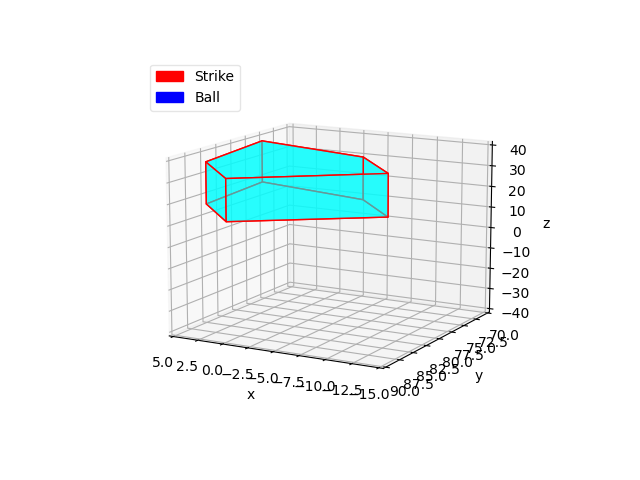

(3.381120262064229, 74.65810037866468, 30.389728552125906)
[[     3.3811      77.958       20.39]
 [     5.1118      84.658      15.078]
 [     1.0298      87.952      12.106]
 [    -11.747      82.613      15.938]
 [    -7.8436      79.746      19.185]]
[[     3.3811      77.958       40.39]
 [     5.1118      84.658      35.078]
 [     1.0298      87.952      32.106]
 [    -11.747      82.613      35.938]
 [    -7.8436      79.746      39.185]]
9.993825654006784


In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
height = zone_dims_dict.get('y_length')
center = (point_order[0][0] ,point_order[0][2] + zone_dims_dict.get('z_length_back'),point_order[0][1] + zone_dims_dict.get('y_length')*.5  )
print(center)
draw_pentagonal_prism(ax = ax,zone_bounds=point_order,zone_dims_dict=zone_dims_dict,center=center)
x_lim = zone_dims_dict.get('x_length_front') + center[0]
y_lim = (zone_dims_dict.get('z_length_front'))+ (zone_dims_dict.get('z_length_back'))
print(y_lim)
# Set axis limits
ax.set_xlim([-15, 5])
ax.set_ylim([70, 90])
ax.set_zlim([-2*height, 2*height])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#Create a legend with a color box
strike_patch = mpatches.Patch(color='red', label='Strike')
ball_patch = mpatches.Patch(color='blue', label='Ball')
plt.legend(handles=[strike_patch, ball_patch], loc='upper left', framealpha=0.5, frameon=True)

# for i in range(len(ball_positions)):
#     if result[i] == 1:
#         ax.scatter(ball_positions[i][0],ball_positions[i][2],ball_positions[i][1],c = 'r',s=200)
#     else:
#         ax.scatter(ball_positions[i][0],ball_positions[i][2],ball_positions[i][1],c = 'b',s=200)

# Enable interactive mode
plt.ion()

# Show the plot
plt.show()

# Pause to allow user interaction
plt.pause(0.1)

# Disable interactive mode
plt.ioff()

# Display the plot
plt.show()

plt.rcParams['savefig.facecolor']='white'
plt.savefig('3d_strikezone_image',bbox_inches="tight")